In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# エンコーダの定義
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3):
        super(Encoder, self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim[0]))
        for i in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_dim[i], hidden_dim[i + 1]))
        self.layers.append(nn.Linear(hidden_dim[-1], output_dim))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        x = self.layers[-1](x)
        return x

# 行動の評価（例:環境でのシミュレーション）
def evaluate_behavior(agent):
    # ここでは簡単な2次元行動記述子を仮定し、ランダムに生成
    behavior_descriptor = np.array([0, 0])  # 2次元の行動記述子
    fitness = np.random.rand()  # 適応度も仮定
    return behavior_descriptor, fitness

# 新奇性の計算
def calculate_novelty(behavior, random_encoder, learned_encoder):
    with torch.no_grad():
        rand_embedding = random_encoder(torch.tensor(behavior, dtype=torch.float32))
    learned_embedding = learned_encoder(torch.tensor(behavior, dtype=torch.float32))
    novelty = torch.norm(rand_embedding - learned_embedding, p=2).item()  # ユークリッド距離
    return novelty

# エージェントのクラス
class Agent:
    def __init__(self):
        self.behavior = None
        self.fitness = 0
        self.novelty = 0

# 世代の進化
def evolve_population(population, random_encoder, learned_encoder, generations=50, population_size=100, offspring_size=50, novelty_threshold=1.0, learning_rate=0.001):
    optimizer = optim.Adam(learned_encoder.parameters(), lr=learning_rate)

    for generation in range(generations):
        print(f"Generation {generation + 1}")

        # 各個体の行動と新奇性を評価
        for agent in population:
            agent.behavior, agent.fitness = evaluate_behavior(agent)
            agent.novelty = calculate_novelty(agent.behavior, random_encoder, learned_encoder)

        # 新奇性に基づく選択（新奇性が高い順に選択）
        population = sorted(population, key=lambda x: x.novelty, reverse=True)
        survivors = population[:population_size]  # 上位個体を次世代に選択

        # 新奇な個体を追加
        offsprings = [Agent() for _ in range(offspring_size)]
        for offspring in offsprings:
            offspring.behavior, offspring.fitness = evaluate_behavior(offspring)
            offspring.novelty = calculate_novelty(offspring.behavior, random_encoder, learned_encoder)

        population = survivors + offsprings

        # エンコーダを訓練
        dataset = [(torch.tensor(agent.behavior, dtype=torch.float32), torch.tensor(agent.behavior, dtype=torch.float32)) for agent in population]
        optimizer.zero_grad()

        for behavior, target in dataset:
            rand_embedding = random_encoder(behavior)
            learned_embedding = learned_encoder(behavior)
            loss = torch.nn.functional.mse_loss(learned_embedding, rand_embedding)  # 埋め込み間の誤差を最小化
            loss.backward()
        optimizer.step()

        print(f"Best novelty: {population[0].novelty}")

    return population

# メイン
if __name__ == "__main__":
    # 行動空間次元、隠れ層次元、エンコーダ出力次元の設定
    input_dim = 2  # 行動記述子の次元（ここでは2次元）
    hidden_dim_rand = [16, 16]
    hidden_dim_learned = [10, 12, 14, 16]
    output_dim = 2  # 埋め込み空間の次元

    # ランダムエンコーダと学習エンコーダを初期化
    random_encoder = Encoder(input_dim, hidden_dim_rand, output_dim, num_layers=3)
    learned_encoder = Encoder(input_dim, hidden_dim_learned, output_dim, num_layers=5)

    # ランダムエンコーダはランダムなパラメータで固定
    for param in random_encoder.parameters():
        param.requires_grad = False

    # 初期個体群の作成
    population_size = 100
    population = [Agent() for _ in range(population_size)]

    # BR-NSアルゴリズムの実行
    evolved_population = evolve_population(population, random_encoder, learned_encoder, generations=100, population_size=100, offspring_size=50)

Generation 1
Best novelty: 0.31496134400367737
Generation 2
Best novelty: 0.3077377676963806
Generation 3
Best novelty: 0.300532728433609
Generation 4
Best novelty: 0.2933497428894043
Generation 5
Best novelty: 0.2861924469470978
Generation 6
Best novelty: 0.27906474471092224
Generation 7
Best novelty: 0.2719704210758209
Generation 8
Best novelty: 0.26488229632377625
Generation 9
Best novelty: 0.257617324590683
Generation 10
Best novelty: 0.25032544136047363
Generation 11
Best novelty: 0.24303384125232697
Generation 12
Best novelty: 0.2357591837644577
Generation 13
Best novelty: 0.22851358354091644
Generation 14
Best novelty: 0.22130677103996277
Generation 15
Best novelty: 0.2141471803188324
Generation 16
Best novelty: 0.20704230666160583
Generation 17
Best novelty: 0.19999925792217255
Generation 18
Best novelty: 0.19302494823932648
Generation 19
Best novelty: 0.18612617254257202
Generation 20
Best novelty: 0.1793096512556076
Generation 21
Best novelty: 0.17258229851722717
Generation 2

In [3]:
BDs_x = np.linspace(-100, 100, 200)
BDs_y = np.linspace(-100, 100, 200)
BDs = np.array([[x, y] for x in BDs_x for y in BDs_y])
novelty_map = np.array([calculate_novelty(BD, random_encoder, learned_encoder) for BD in BDs])

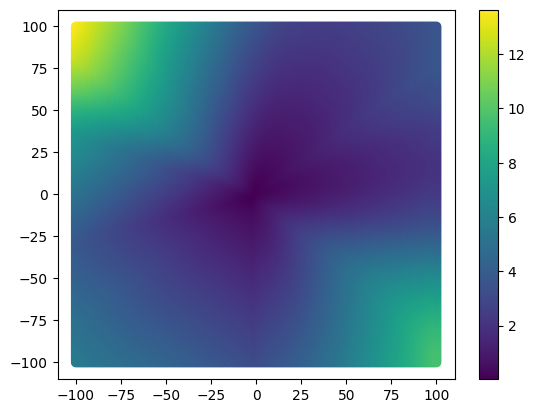

In [4]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(BDs[:, 0], BDs[:, 1], c=novelty_map, cmap="viridis")
plt.colorbar()
plt.show()

In [5]:
np.max(novelty_map)

13.640409469604492

In [6]:
np.min(novelty_map)

0.022361675277352333